Notebook 5
==============
Further Analysis

# Outline
The aim is to further investigate the models developed in the third notebook.
We will identify the the sensitivity of the model performances regarding 
1. the amount of training data
2. the amount of features used for training

# Import Modules, Data and Model 

In [1]:
# Import the modules
import pyfra
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from joblib import load, dump
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import VarianceThreshold, SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils import random
from sklearn.metrics import f1_score, accuracy_score, recall_score

In [2]:
df = pd.read_pickle('../data/df.p')
n_rows_complete = len(df)

In [3]:
# Check whether or not the data is up-to-date (file can't be tracked on github because of it's file size)
pd.testing.assert_frame_equal(left=(pd.read_csv('../data/df_check_info.csv', index_col=0)), \
                         right=pyfra.df_testing_info(df),\
                         check_dtype=False, check_exact=False)

In [4]:
rus = RandomUnderSampler(random_state=23)

In [5]:
data = df.drop(columns='Severity',axis=1).select_dtypes(include=np.number).dropna(axis=1)
target = df['Severity']
data, target = rus.fit_resample(X=data, y=target)

In [6]:
target.value_counts()

1    6741
2    6741
3    6741
4    6741
Name: Severity, dtype: int64

In [7]:
data = df.drop(columns='Severity',axis=1).select_dtypes(include=np.number).dropna(axis=1)
target = df['Severity']
data.sample(frac=0.5).to_pickle('../data/streamlit_example.p')

In [8]:
X_train, X_test, y_train, y_test  = train_test_split(data, target, test_size=0.2 ,random_state=23)

In [9]:
constant_filter = VarianceThreshold(threshold=0.01).fit(X_train)
std_scaler = StandardScaler().fit(X_train)
preprocessing_pipeline = Pipeline(steps=[#('var_threshold', constant_filter),
                                 ('scaler', std_scaler)])
dump(preprocessing_pipeline, filename='../models/preprocessing_pipeline.joblib')

['../models/preprocessing_pipeline.joblib']

We use the SVC model as well as the logistic regression model from notebook 3 to measure the performances.
Note that we only can use the optimized parameters from the grid search, i.e. we will have to fit these models again in every step.

In [10]:
log_reg_clf = load('../models/log_reg_clf.joblib')
svc = load('../models/svc.joblib')

# Relation between Amount of Training Data and Model Performance

## Hypothesis
The performance of machine learning models depends on the quantity of input data (also to the quality, but this will not be discussed in this notebook).
Training a model with large amounts of data, however, can result in long training times. We will compare the performance of our models trained on different amounts of data.
We expect the performance to increase with the amount of data, while the variance should decrease because of the bigger sample size. 

## Experiment

In [11]:
result_metrics = pd.DataFrame(columns=['model', 'n_rows','f1', 'accuracy', 'recall'])
result_metrics.index.name = 'id'
result_metrics

,model,n_rows,f1,accuracy,recall
id,,,,,


In [12]:
# Creating a function to compute and store the results for the respective model
def fit_evaluate(model_label, model, n_rows, result_df):
    id = result_df.shape[0]
    result_df.loc[id, 'Model Name'] = model_label
    result_df.loc[id, 'model'] = model
    result_df.loc[id, 'n_rows'] = n_rows
    print(f'Splitting {n_rows} rows of data...')
    sample_indices = random.sample_without_replacement(n_population=len(target), 
                                                       n_samples=n_rows)
    data_sample = data.iloc[sample_indices]
    target_sample = target.iloc[sample_indices]

    # We will increment the random_state at each repetition to get a more robust result.
    X_train, X_test, y_train, y_test = train_test_split(data_sample, 
                                                        target_sample, 
                                                        test_size=0.2, 
                                                        random_state=23+id,
                                                        stratify=target_sample)
    X_train = preprocessing_pipeline.fit_transform(X_train, y_train)
    X_test = preprocessing_pipeline.transform(X_test)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    result_df.loc[id, 'f1'] = f1_score(y_true=y_test, y_pred=y_pred, average='weighted')
    result_df.loc[id, 'accuracy'] = accuracy_score(y_true=y_test, y_pred=y_pred)
    result_df.loc[id, 'recall'] = recall_score(y_true=y_test, y_pred=y_pred, average='weighted')
    result_df.loc[id, 'pipeline'] = preprocessing_pipeline
    return result_df 

In [13]:
n_repetitions = 2
for n_rows in [500, 1_000, 2_000, 5_000, 10_000, 20_000, 50_000]:
    for i_repetition in range(n_repetitions):
        print('Repetition nr.', i_repetition)
        result_metrics = fit_evaluate('Logistic Regression', log_reg_clf, n_rows, result_metrics)
        result_metrics = fit_evaluate('SVC', svc, n_rows, result_metrics)

# Show the interim result                               
result_metrics

Repetition nr. 0
Splitting 500 rows of data...
Splitting 500 rows of data...


Repetition nr. 1
Splitting 500 rows of data...
Splitting 500 rows of data...


Repetition nr. 0
Splitting 1000 rows of data...


Splitting 1000 rows of data...


Repetition nr. 1
Splitting 1000 rows of data...


Splitting 1000 rows of data...


Repetition nr. 0
Splitting 2000 rows of data...


Splitting 2000 rows of data...


Repetition nr. 1
Splitting 2000 rows of data...


Splitting 2000 rows of data...


Repetition nr. 0
Splitting 5000 rows of data...


Splitting 5000 rows of data...


Repetition nr. 1
Splitting 5000 rows of data...


Splitting 5000 rows of data...


Repetition nr. 0
Splitting 10000 rows of data...


Splitting 10000 rows of data...


Repetition nr. 1
Splitting 10000 rows of data...


Splitting 10000 rows of data...


Repetition nr. 0
Splitting 20000 rows of data...


Splitting 20000 rows of data...


Repetition nr. 1
Splitting 20000 rows of data...


Splitting 20000 rows of data...


Repetition nr. 0
Splitting 50000 rows of data...


Splitting 50000 rows of data...


Repetition nr. 1
Splitting 50000 rows of data...


Splitting 50000 rows of data...


,model,n_rows,f1,accuracy,recall,Model Name,pipeline
id,,,,,,,
0,"LogisticRegression(C=0.1, max_iter=1000, solve...",500,0.352195,0.35,0.35,Logistic Regression,(StandardScaler())
1,"SVC(C=0.5, cache_size=4000)",500,0.38299,0.44,0.44,SVC,(StandardScaler())
2,"LogisticRegression(C=0.1, max_iter=1000, solve...",500,0.384866,0.38,0.38,Logistic Regression,(StandardScaler())
3,"SVC(C=0.5, cache_size=4000)",500,0.353571,0.41,0.41,SVC,(StandardScaler())
4,"LogisticRegression(C=0.1, max_iter=1000, solve...",1000,0.431909,0.44,0.44,Logistic Regression,(StandardScaler())
5,"SVC(C=0.5, cache_size=4000)",1000,0.362965,0.46,0.46,SVC,(StandardScaler())
6,"LogisticRegression(C=0.1, max_iter=1000, solve...",1000,0.462441,0.47,0.47,Logistic Regression,(StandardScaler())
7,"SVC(C=0.5, cache_size=4000)",1000,0.36779,0.465,0.465,SVC,(StandardScaler())
8,"LogisticRegression(C=0.1, max_iter=1000, solve...",2000,0.49582,0.505,0.505,Logistic Regression,(StandardScaler())


In [14]:
# Save trained and data for streamlit
dump(result_metrics['model'].iloc[-2], '../models/log_reg_nb5.joblib')
dump(result_metrics['model'].iloc[-1], '../models/svc_nb5.joblib')
dump(result_metrics['pipeline'].iloc[-2], '../models/log_reg_preprocessing_pipeline.joblib')
dump(result_metrics['pipeline'].iloc[-1], '../models/svc_preprocessing_pipeline.joblib')

['../models/svc_preprocessing_pipeline.joblib']

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.


findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.


findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.


findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.


findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.


findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.


findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


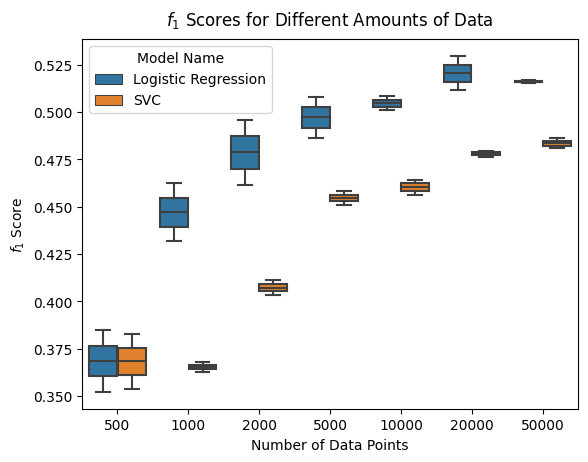

In [15]:
sns.boxplot(data=result_metrics, x='n_rows', y = 'f1', hue='Model Name')
plt.xlabel('Number of Data Points');
plt.ylabel('$f_1$ Score');
plt.title('$f_1$ Scores for Different Amounts of Data', pad=10);
plt.savefig('../figures/n_rows_f1.png');
plt.savefig('../figures/n_rows_f1.svg');

## Conclusion
We can see that the performance increases with the amount of data. We can also observe that the performance is already reaching a plateau, which means that the amount of data for training is already sufficient. We expected the variance to decrease, but nat to that extent. The reason for the high variance in the beginning could be that not only the amount of training data is smaller, but also the amount of test data.

# Impact of Number of Variables

## Hypothesis
We expect the number of variables to have an important impact on the performance. We are dealing with a large number of features in our dataset, and we expect some of these variables to not have an impact. We use k-best selection to reduce the number of features. This means, that the most important features will be used early on and the least important features will be added later. Hence we expect the performance to reach a plateau.

## Experiment

In [16]:
k_feat_metrics = pd.DataFrame(columns=['model', 'f1', 'accuracy', 'recall'])
k_feat_metrics.index.name = 'id'
k_feat_metrics

,model,f1,accuracy,recall
id,,,,


In [17]:
n_rows = 50_000
sample_indices = random.sample_without_replacement(n_population=len(target), 
                                                   n_samples=n_rows)

def k_features_fit_evaluate(model_label, model, k_features, result_df):
    id = result_df.shape[0]
    result_df.loc[id, 'model_label'] = model_label
    result_df.loc[id, 'model'] = model
    result_df.loc[id, 'k_features'] = k_features
    data_sample = data.iloc[sample_indices]
    target_sample = target.iloc[sample_indices]
    X_train, X_test, y_train, y_test = train_test_split(data_sample, 
                                                        target_sample, 
                                                        test_size=0.2,
                                                        random_state=23+id,  
                                                        stratify=target_sample)
    # Preprocessing
    X_train = preprocessing_pipeline.fit_transform(X_train, y_train)
    X_test = preprocessing_pipeline.transform(X_test)

    # Select k best features
    kbest_selector = SelectKBest(k=k_features)
    X_train = kbest_selector.fit_transform(X=X_train, y=y_train)
    X_test = kbest_selector.transform(X=X_test)

    # fit model and predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Compute scores
    result_df.loc[id, 'f1'] = f1_score(y_true=y_test, y_pred=y_pred, average='weighted')
    result_df.loc[id, 'accuracy'] = accuracy_score(y_true=y_test, y_pred=y_pred)
    result_df.loc[id, 'recall'] = recall_score(y_true=y_test, y_pred=y_pred, average='weighted')
    return result_df

In [18]:
n_repetitions = 5
for k_features in [5, 10, 20, 50, 100, 140]:
    for i_repetition in range(n_repetitions):
        print('Repetition no:', i_repetition+1)
        print('Number of features:', k_features)
        k_feat_metrics = k_features_fit_evaluate('logistic_regression', log_reg_clf, k_features, k_feat_metrics)

# Show the interim result                               
k_feat_metrics
print(k_feat_metrics)

Repetition no: 1
Number of features: 5


C:\Users\kayla\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 32 154] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\kayla\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Repetition no: 2
Number of features: 5


C:\Users\kayla\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 32 154 297 298] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\kayla\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Repetition no: 3
Number of features: 5


C:\Users\kayla\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 32 154] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\kayla\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Repetition no: 4
Number of features: 5


C:\Users\kayla\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 32 152 154 176 182 260 298] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\kayla\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Repetition no: 5
Number of features: 5


C:\Users\kayla\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 32 152 154 272] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\kayla\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Repetition no: 1
Number of features: 10


C:\Users\kayla\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 32 152 154] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\kayla\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Repetition no: 2
Number of features: 10


C:\Users\kayla\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 32 154 323] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\kayla\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Repetition no: 3
Number of features: 10


C:\Users\kayla\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 32 154 295] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\kayla\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Repetition no: 4
Number of features: 10


C:\Users\kayla\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 32 154 176 182] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\kayla\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Repetition no: 5
Number of features: 10


C:\Users\kayla\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 32 154] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\kayla\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Repetition no: 1
Number of features: 20


C:\Users\kayla\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 32 154] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\kayla\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Repetition no: 2
Number of features: 20


C:\Users\kayla\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 32 154 176 182 188] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\kayla\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Repetition no: 3
Number of features: 20


C:\Users\kayla\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 32 154 176 182 295] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\kayla\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Repetition no: 4
Number of features: 20


C:\Users\kayla\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 32 154 176 182 295] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\kayla\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Repetition no: 5
Number of features: 20


C:\Users\kayla\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 32 154 176 182 272] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\kayla\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Repetition no: 1
Number of features: 50


C:\Users\kayla\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 32 154 295] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\kayla\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Repetition no: 2
Number of features: 50


C:\Users\kayla\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 32 154 272] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\kayla\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Repetition no: 3
Number of features: 50


C:\Users\kayla\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 32 150 152 154 298] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\kayla\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Repetition no: 4
Number of features: 50


C:\Users\kayla\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 32 154 272] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\kayla\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Repetition no: 5
Number of features: 50


C:\Users\kayla\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 32 152 154] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\kayla\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Repetition no: 1
Number of features: 100


C:\Users\kayla\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 32 154] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\kayla\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Repetition no: 2
Number of features: 100


C:\Users\kayla\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 32 154 176 182] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\kayla\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Repetition no: 3
Number of features: 100


C:\Users\kayla\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 32 154 272] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\kayla\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Repetition no: 4
Number of features: 100


C:\Users\kayla\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 32 154 176 182] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\kayla\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Repetition no: 5
Number of features: 100


C:\Users\kayla\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 22  32 154] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\kayla\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Repetition no: 1
Number of features: 140


C:\Users\kayla\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 32 154 260 272 295] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\kayla\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Repetition no: 2
Number of features: 140


C:\Users\kayla\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 32 154 176 182 297] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\kayla\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Repetition no: 3
Number of features: 140


C:\Users\kayla\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 32 154 272 298] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\kayla\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Repetition no: 4
Number of features: 140


C:\Users\kayla\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 32 154 272] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\kayla\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Repetition no: 5
Number of features: 140


C:\Users\kayla\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 32 152 154 272] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\kayla\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


                                                model        f1 accuracy  \
id                                                                         
0   LogisticRegression(C=0.1, max_iter=1000, solve...  0.395405   0.4771   
1   LogisticRegression(C=0.1, max_iter=1000, solve...  0.398685   0.4808   
2   LogisticRegression(C=0.1, max_iter=1000, solve...  0.386926   0.4683   
3   LogisticRegression(C=0.1, max_iter=1000, solve...  0.402743   0.4835   
4   LogisticRegression(C=0.1, max_iter=1000, solve...  0.389315    0.473   
5   LogisticRegression(C=0.1, max_iter=1000, solve...  0.421901   0.4821   
6   LogisticRegression(C=0.1, max_iter=1000, solve...  0.414404   0.4757   
7   LogisticRegression(C=0.1, max_iter=1000, solve...  0.419032   0.4799   
8   LogisticRegression(C=0.1, max_iter=1000, solve...  0.415746   0.4781   
9   LogisticRegression(C=0.1, max_iter=1000, solve...  0.416542   0.4785   
10  LogisticRegression(C=0.1, max_iter=1000, solve...  0.466488   0.5031   
11  Logistic

In [19]:
k_feat_metrics

,model,f1,accuracy,recall,model_label,k_features
id,,,,,,
0,"LogisticRegression(C=0.1, max_iter=1000, solve...",0.395405,0.4771,0.4771,logistic_regression,5.0
1,"LogisticRegression(C=0.1, max_iter=1000, solve...",0.398685,0.4808,0.4808,logistic_regression,5.0
2,"LogisticRegression(C=0.1, max_iter=1000, solve...",0.386926,0.4683,0.4683,logistic_regression,5.0
3,"LogisticRegression(C=0.1, max_iter=1000, solve...",0.402743,0.4835,0.4835,logistic_regression,5.0
4,"LogisticRegression(C=0.1, max_iter=1000, solve...",0.389315,0.473,0.473,logistic_regression,5.0
5,"LogisticRegression(C=0.1, max_iter=1000, solve...",0.421901,0.4821,0.4821,logistic_regression,10.0
6,"LogisticRegression(C=0.1, max_iter=1000, solve...",0.414404,0.4757,0.4757,logistic_regression,10.0
7,"LogisticRegression(C=0.1, max_iter=1000, solve...",0.419032,0.4799,0.4799,logistic_regression,10.0
8,"LogisticRegression(C=0.1, max_iter=1000, solve...",0.415746,0.4781,0.4781,logistic_regression,10.0


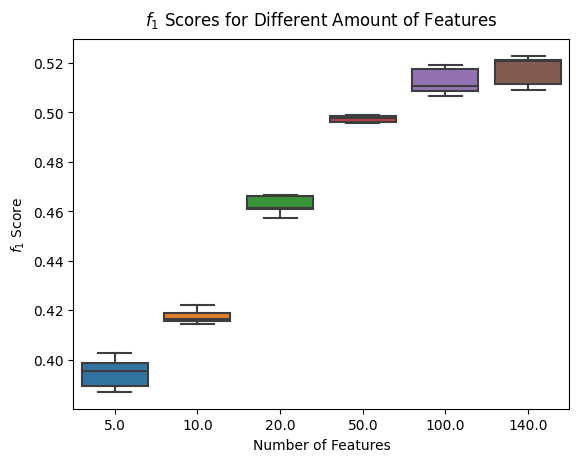

In [20]:
sns.boxplot(data=k_feat_metrics, x='k_features', y = 'f1');
plt.xlabel('Number of Features');
plt.ylabel('$f_1$ Score');
plt.title('$f_1$ Scores for Different Amount of Features', pad=10);
plt.savefig('../figures/k_features_f1.png');
plt.savefig('../figures/k_features_f1.svg');

The plot shows that the number of features used for training has a huge impact on the performance.
The use of the kbest-selector implies that the average importance is higher for the thirst features than for the latter.
We can indeed observe that the performance comes to a halt somewhere between 50 and 140 features. 

# Conclusion
In this notebook we investigated the impact of two different parameters on the model performance: The amount of training data and the number of features.
The respective conclusions affirm the notion that it is important to have a certain amount of data to train a model with, but that the marginal improvement decreases
with an increasing amount of data.

The problem is, that the knowledge of a decent amount of data is not known beforehand. With our investigations in this notebook we were able to justify our decision to use only a
subset of data for training and not the whole dataset.
